## Initial Settings

1.  Load the relevant libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV,RandomizedSearchCV
from sklearn.metrics import root_mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import Ridge

2.  Test model and parameters for each model

In [2]:
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'XGBoost': XGBRegressor(random_state=42)
}

param_grids = {
    'Linear Regression': {},
    'Random Forest': {'model__n_estimators': [100, 200], 'model__max_depth': [None, 10, 20]},
    'Gradient Boosting': {'model__n_estimators': [100, 200], 'model__learning_rate': [0.01, 0.1]},
    'XGBoost': {'model__n_estimators': [100, 200], 'model__learning_rate': [0.01, 0.1], 'model__max_depth': [3, 5]}
}

3.  Methods used for various tasks

In [3]:
def generate_graph_v1(df):
    # Set up the plot
    fig, ax = plt.subplots(figsize=(16, 10))

    # Define width of bars and positions
    bar_width = 0.12  # Increased for better spacing
    metric_columns = df.columns[1:]  # Exclude the 'Model' column
    num_metrics = len(metric_columns)
    num_models = len(df)

    # Create bars for each model
    for i, (index, row) in enumerate(df.iterrows()):
        x = np.arange(num_metrics) + i * bar_width
        bars = ax.bar(x, row[1:], width=bar_width, label=row['Model'])

        # Add value labels on the bars
        for j, v in enumerate(row[1:]):
            if v > 0:  # Only display labels for non-zero bars
                ax.text(x[j], v, f'{v:.4f}', ha='center', va='bottom', rotation=30, fontsize=10, color='black')

    # Customize the plot
    ax.set_xlabel('Metrics', fontweight='bold', fontsize=18)
    ax.set_ylabel('Scores', fontweight='bold', fontsize=18)
    ax.set_title('Comparison of Metrics Across Models', fontweight='bold', fontsize=26, pad=20)
    ax.set_xticks(np.arange(num_metrics) + bar_width * (num_models - 1) / 2)
    ax.set_xticklabels(metric_columns, rotation=45, ha='right', fontsize=14)

    # Add a legend
    ax.legend(title='Models', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=14, title_fontsize=16)

    # Adjust layout and display
    plt.tight_layout()
    plt.show()


In [4]:
def generate_graph_v2(df):
    # Set up the plot
    fig, ax = plt.subplots(figsize=(20, 12))

    # Define width of bars and positions
    bar_width = 0.15  # Increased for better spacing
    metric_columns = df.columns[1:]  # Exclude the 'Model' column
    num_metrics = len(metric_columns)
    num_models = len(df)

    # Create bars for each metric
    for i, metric in enumerate(metric_columns):
        x = np.arange(num_models) + i * bar_width
        bars = ax.bar(x, df[metric], width=bar_width, label=metric)
        
        # Add value labels on the bars
        for bar in bars:
            height = bar.get_height()
            if height > 0:  # Only display labels for non-zero bars
                ax.text(bar.get_x() + bar.get_width()/2., height,
                        f'{height:.3f}', ha='center', va='bottom', rotation=30, fontsize=10, color='black')

    # Customize the plot
    ax.set_xlabel('Models', fontweight='bold', fontsize=18)
    ax.set_ylabel('Scores', fontweight='bold', fontsize=18)
    ax.set_title('Comparison of Metrics Across Models', fontweight='bold', fontsize=26, pad=20)
    ax.set_xticks(np.arange(num_models) + bar_width * (num_metrics - 1) / 2)
    ax.set_xticklabels(df['Model'], rotation=45, ha='right', fontsize=14)

    # Add a legend
    ax.legend(title='Metrics', bbox_to_anchor=(1.01, 1), loc='upper left', fontsize=14, title_fontsize=16)

    # Adjust layout and display
    plt.tight_layout()
    plt.show()


In [5]:
def generate_graph_v3(df):
    metrics = df.columns[1:]  # Exclude 'Model' column
    num_metrics = len(metrics)

    fig, axes = plt.subplots(nrows=(num_metrics + 2) // 3, ncols=3, figsize=(18, 12))
    axes = axes.flatten()

    for i, metric in enumerate(metrics):
        axes[i].bar(df['Model'], df[metric], color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
        axes[i].set_title(metric, fontsize=14, fontweight='bold')
        axes[i].set_ylabel(metric, fontsize=12)
        axes[i].tick_params(axis='x', rotation=45)

        # Add value labels on the bars
        for j, value in enumerate(df[metric]):
            axes[i].text(j, value, f'{value:.3f}', ha='center', va='bottom', fontsize=10, rotation=45)

    # Hide any empty subplots
    for j in range(i+1, len(axes)):
        axes[j].set_visible(False)

    plt.tight_layout()
    plt.show()

In [6]:
def calculate_metrics(y_true, y_pred, threshold=5.0):
    correct_predictions = np.abs(y_true - y_pred) <= threshold
    accuracy = np.sum(correct_predictions) / len(y_true)
    return {
        'R²': r2_score(y_true, y_pred),
        'MAE': mean_absolute_error(y_true, y_pred),
        'RMSE': np.sqrt(root_mean_squared_error(y_true, y_pred)),
        'Accuracy': accuracy
    }

In [7]:
def execute_training(X, y, test_size=0.2, random_state=42):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    
    
    results = []
    trained_models = {}

    for name, model in tqdm(models.items(), desc="Training Models"):
        # Define the pipeline
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('poly', PolynomialFeatures(degree=2, include_bias=False)),
            ('model', model)
        ])        
    
        # Fit the pipeline
        pipeline.fit(X_train, y_train)
    
        # Make predictions
        y_pred = pipeline.predict(X_test)
            
        metrics = calculate_metrics(y_test, y_pred)
        cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='r2')
        metrics['Cross-Val R²'] = np.mean(cv_scores)
        
        # Add model name to metrics
        metrics['Model'] = name
        
        # Append results
        results.append(metrics)
        
        # Store the trained pipeline
        trained_models[name] = pipeline
                
    # Convert the results to a DataFrame
    results_df = pd.DataFrame(results)

    # Reorder columns to have 'Model' as the first column
    cols = ['Model'] + [col for col in results_df.columns if col != 'Model']
    results_df = results_df[cols]

    # Return the DataFrame and trained models
    return results_df, trained_models

4.  Read the dataset that resulted from Data Analysis

In [8]:
experiment_dataset = pd.read_csv('Experiment_3_filtered_data.csv')

In [9]:
X = experiment_dataset.drop(['SHAP Match Percentage'], axis=1)
y = experiment_dataset['SHAP Match Percentage']

## EXP - 1: Test the models with Standard dataset

In [10]:
result_exp_1,trained_model_1 = execute_training(X, y)

Training Models:   0%|          | 0/4 [00:00<?, ?it/s]

In [11]:
result_exp_1

,Model,R²,MAE,RMSE,Accuracy,Cross-Val R²
0,Linear Regression,0.446413,5.121614,2.826783,0.639500,0.451402
1,Random Forest,0.751875,2.706221,2.312935,0.819125,0.702099
2,Gradient Boosting,0.541746,4.099220,2.696326,0.687750,0.526104
3,XGBoost,0.664952,3.406111,2.493289,0.739875,0.630658


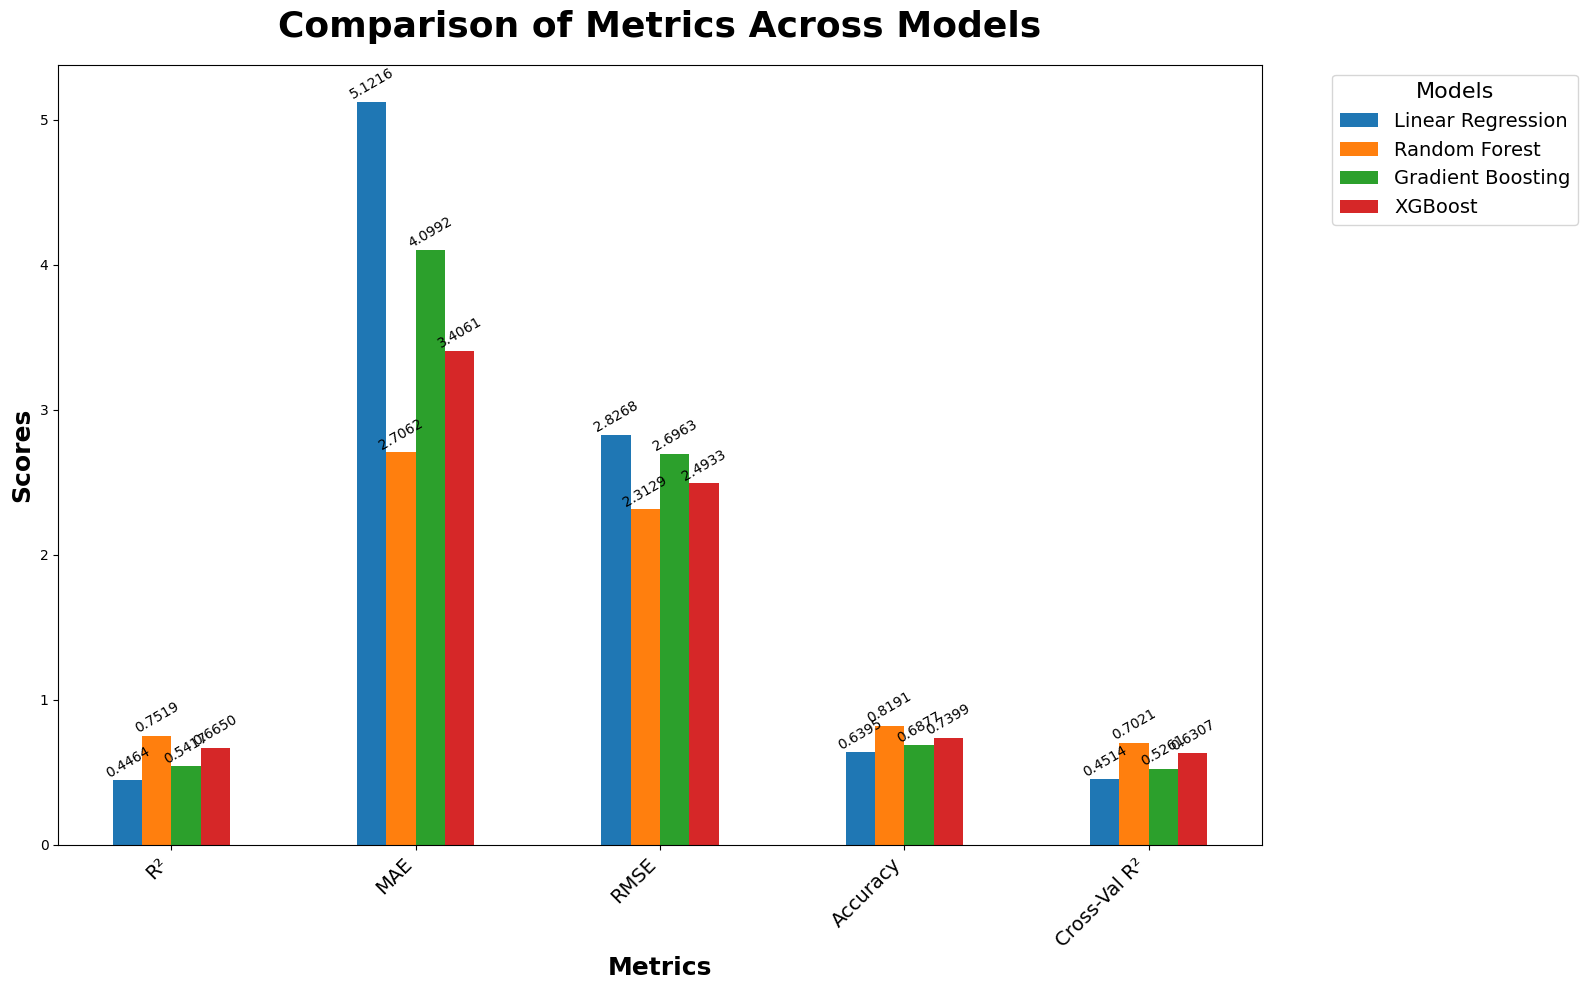

In [12]:
generate_graph_v1(result_exp_1)

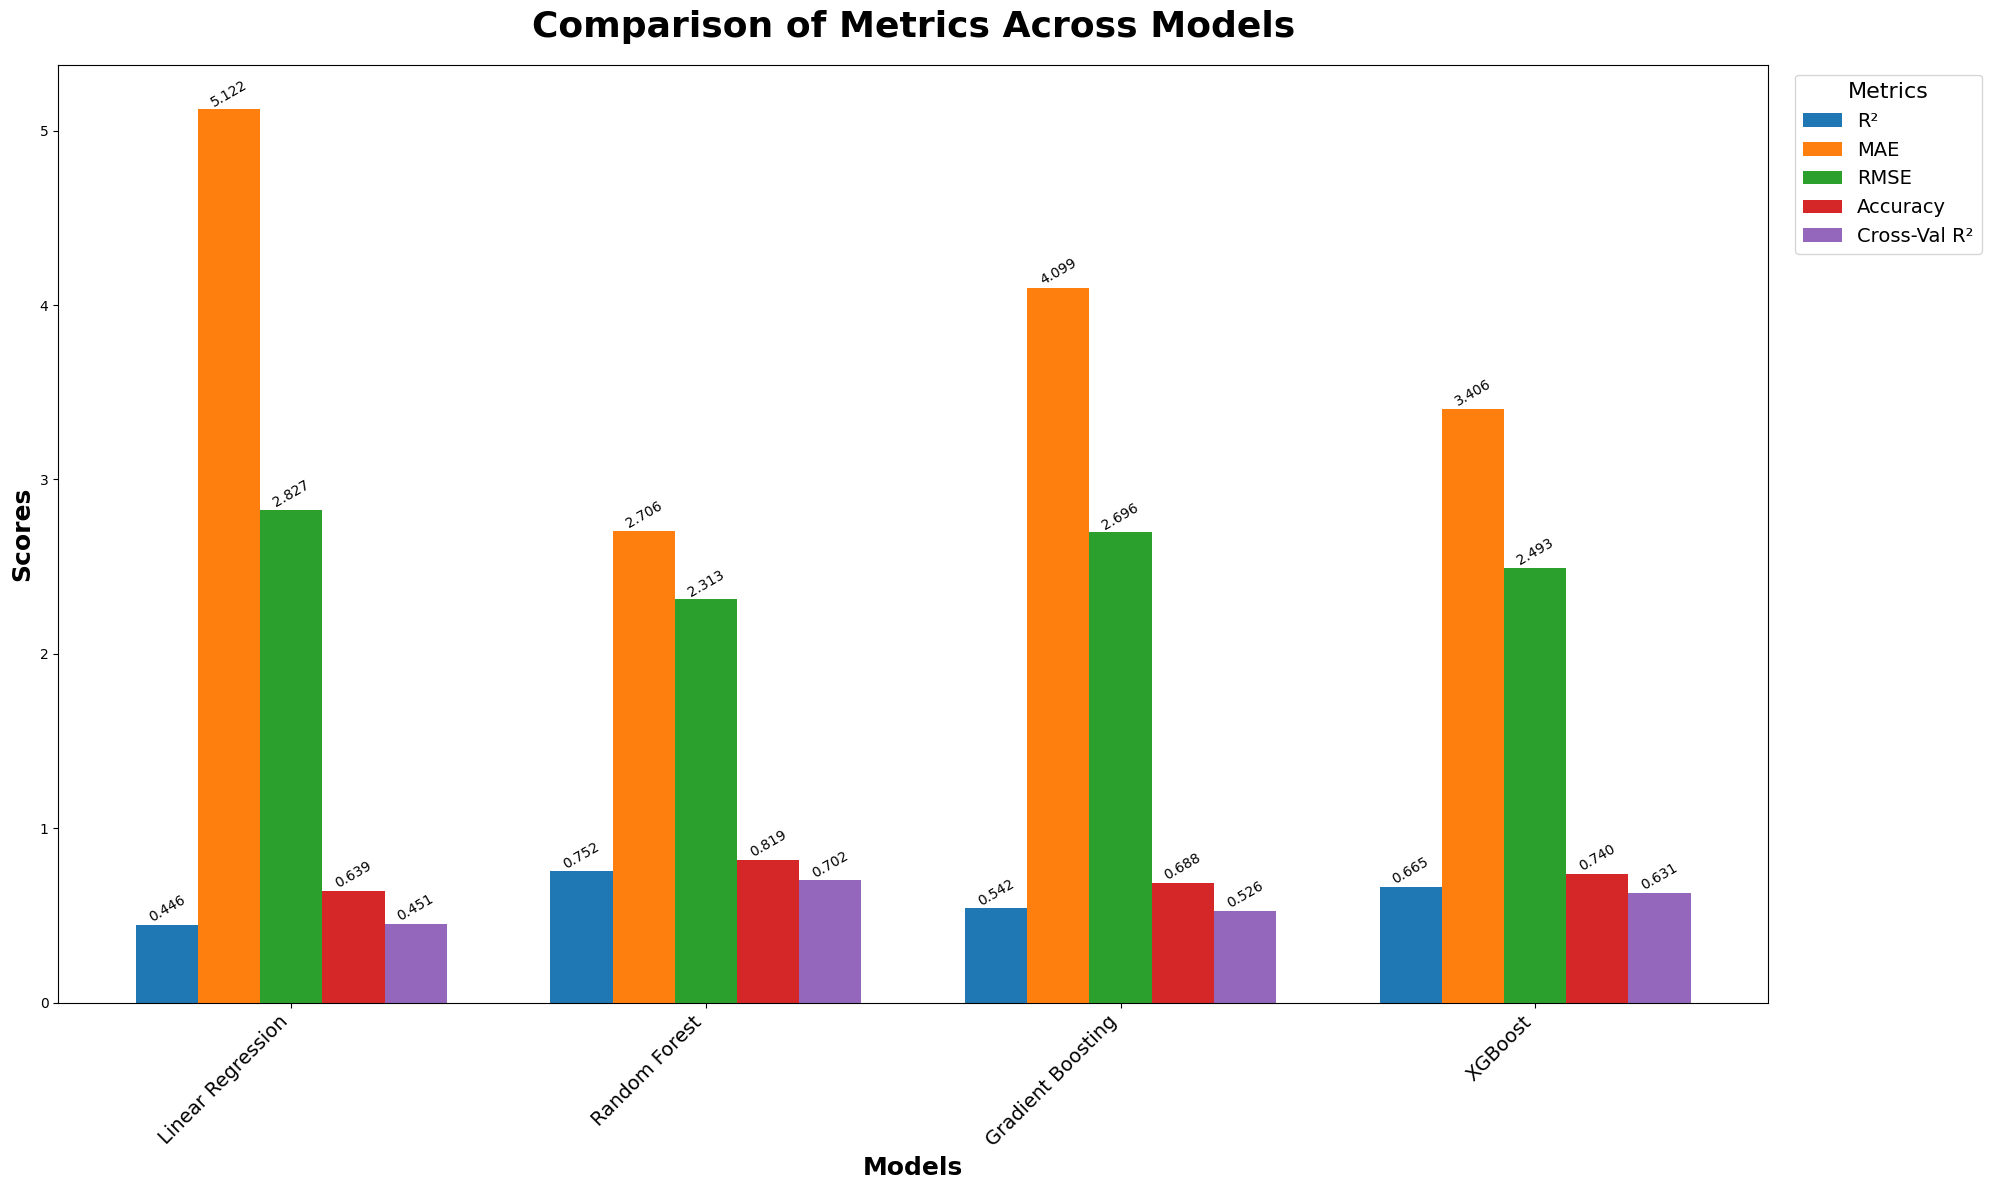

In [13]:
generate_graph_v2(result_exp_1)

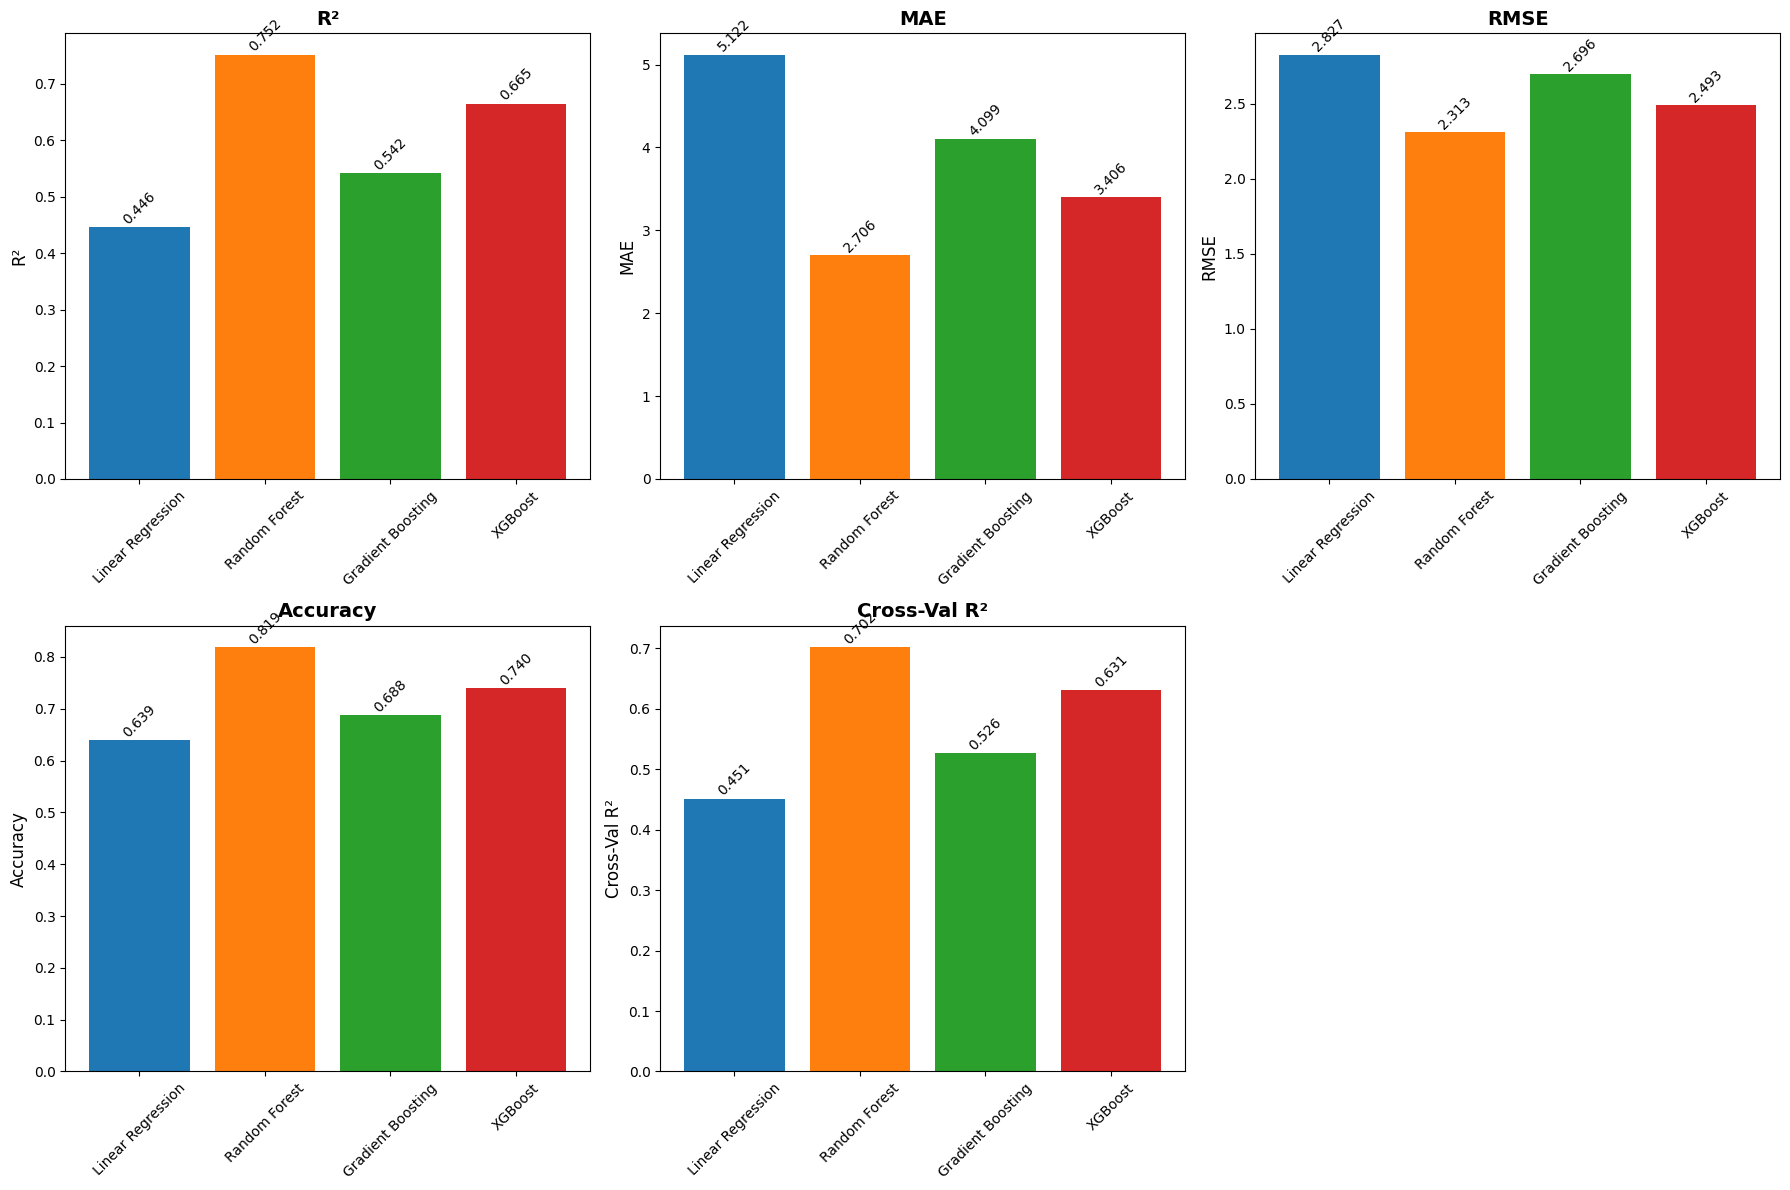

In [14]:
generate_graph_v3(result_exp_1)

## EXP - 2: Test the models with Feature Engineering

1.  Generate some new feature based on data analysis

In [15]:
# Feature engineering
X['RAE_sMAPE_interaction'] = X['RAE'] * X['sMAPE']
X['log_MedAE'] = np.log1p(X['MedAE'])
X['log_Max_Error'] = np.log1p(X['Max Error'])
X['Sample_Size_R2'] = X['Sample Size'] * X['R²']
X['negative_r2'] = X['R²'] < 0

2.  Feature Selection

In [16]:
# Feature selection

k = 5  # THIS CAN BE CHANGED

selector = SelectKBest(score_func=f_regression, k=k)
selector.fit(X, y)
cols = selector.get_support(indices=True)
X_selected = X.iloc[:, cols]

3.  Final Features Definition

In [17]:
# Combine selected features with engineered features
engineered_features = ['RAE_sMAPE_interaction', 'log_MedAE', 'log_Max_Error', 'Sample_Size_R2', 'negative_r2']

features_with_feature_engineering = list(X_selected.columns) + engineered_features

# Create final feature set
X_with_feature_engineering = X[features_with_feature_engineering]
print("Features with feature enginering:", features_with_feature_engineering)

Features with feature enginering: ['RAE', 'sMAPE', 'PICP', 'RAE_sMAPE_interaction', 'Sample_Size_R2', 'RAE_sMAPE_interaction', 'log_MedAE', 'log_Max_Error', 'Sample_Size_R2', 'negative_r2']


In [18]:
result_exp_2,trained_model_2 = execute_training(X_with_feature_engineering, y)

Training Models:   0%|          | 0/4 [00:00<?, ?it/s]

In [19]:
result_exp_2

,Model,R²,MAE,RMSE,Accuracy,Cross-Val R²
0,Linear Regression,0.476314,4.813494,2.787813,0.661500,0.467620
1,Random Forest,0.750054,2.710986,2.317168,0.816500,0.699085
2,Gradient Boosting,0.542099,4.097364,2.695807,0.689250,0.523969
3,XGBoost,0.664231,3.396004,2.494629,0.738125,0.631359


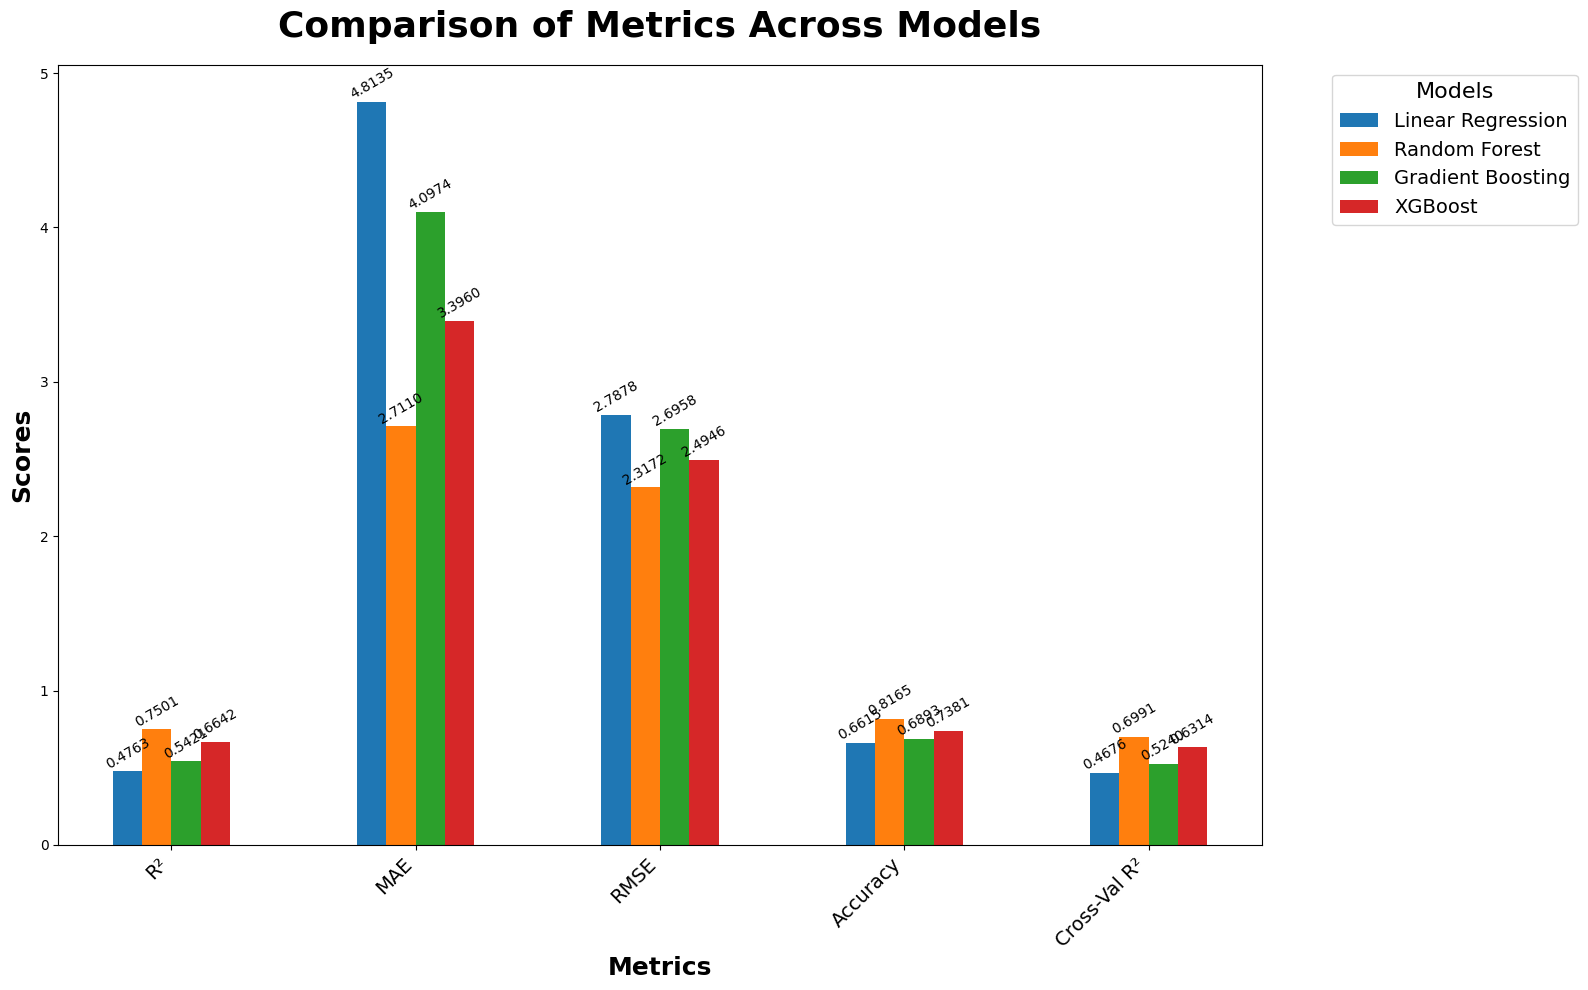

In [20]:
generate_graph_v1(result_exp_2)

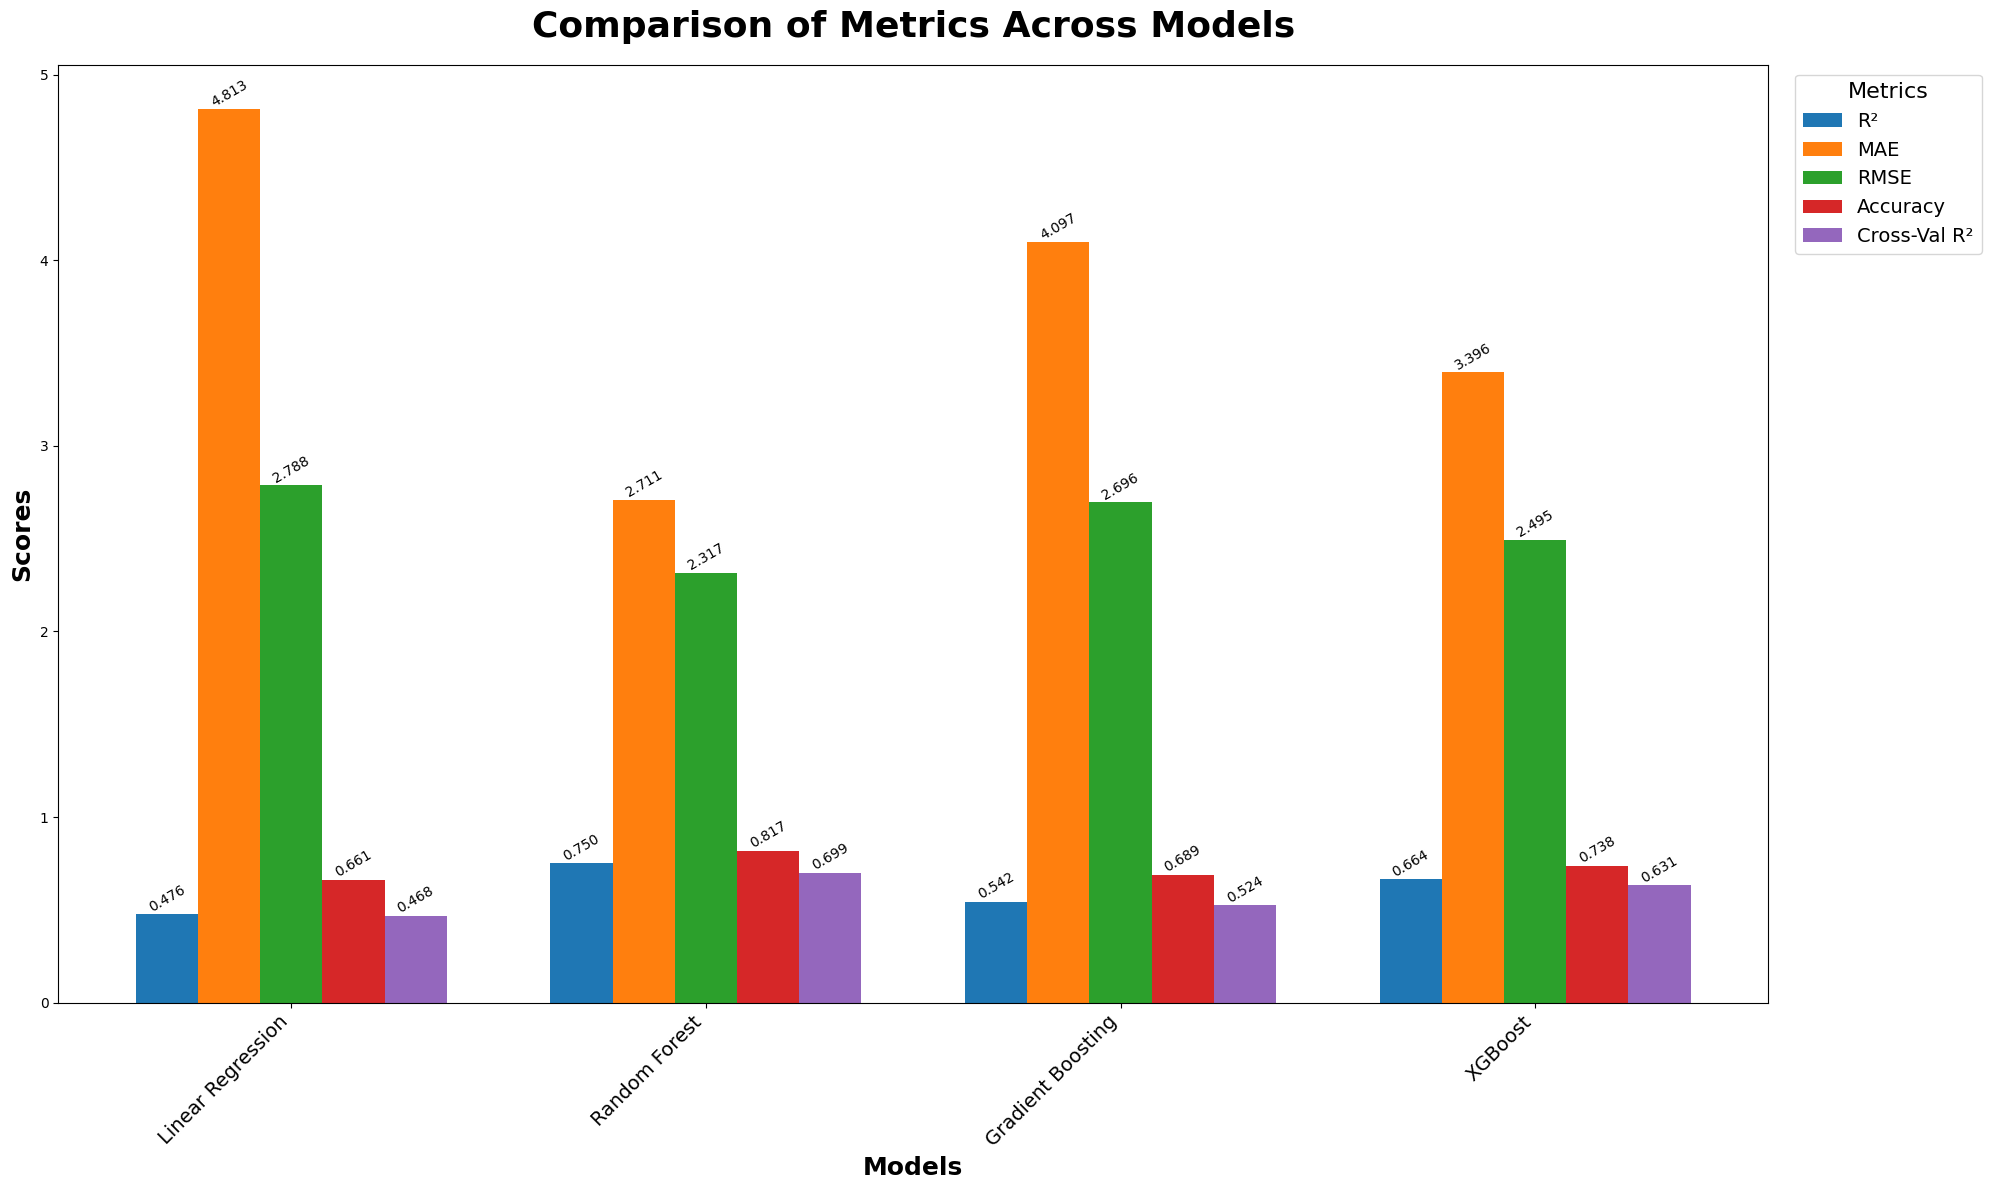

In [21]:
generate_graph_v2(result_exp_2)

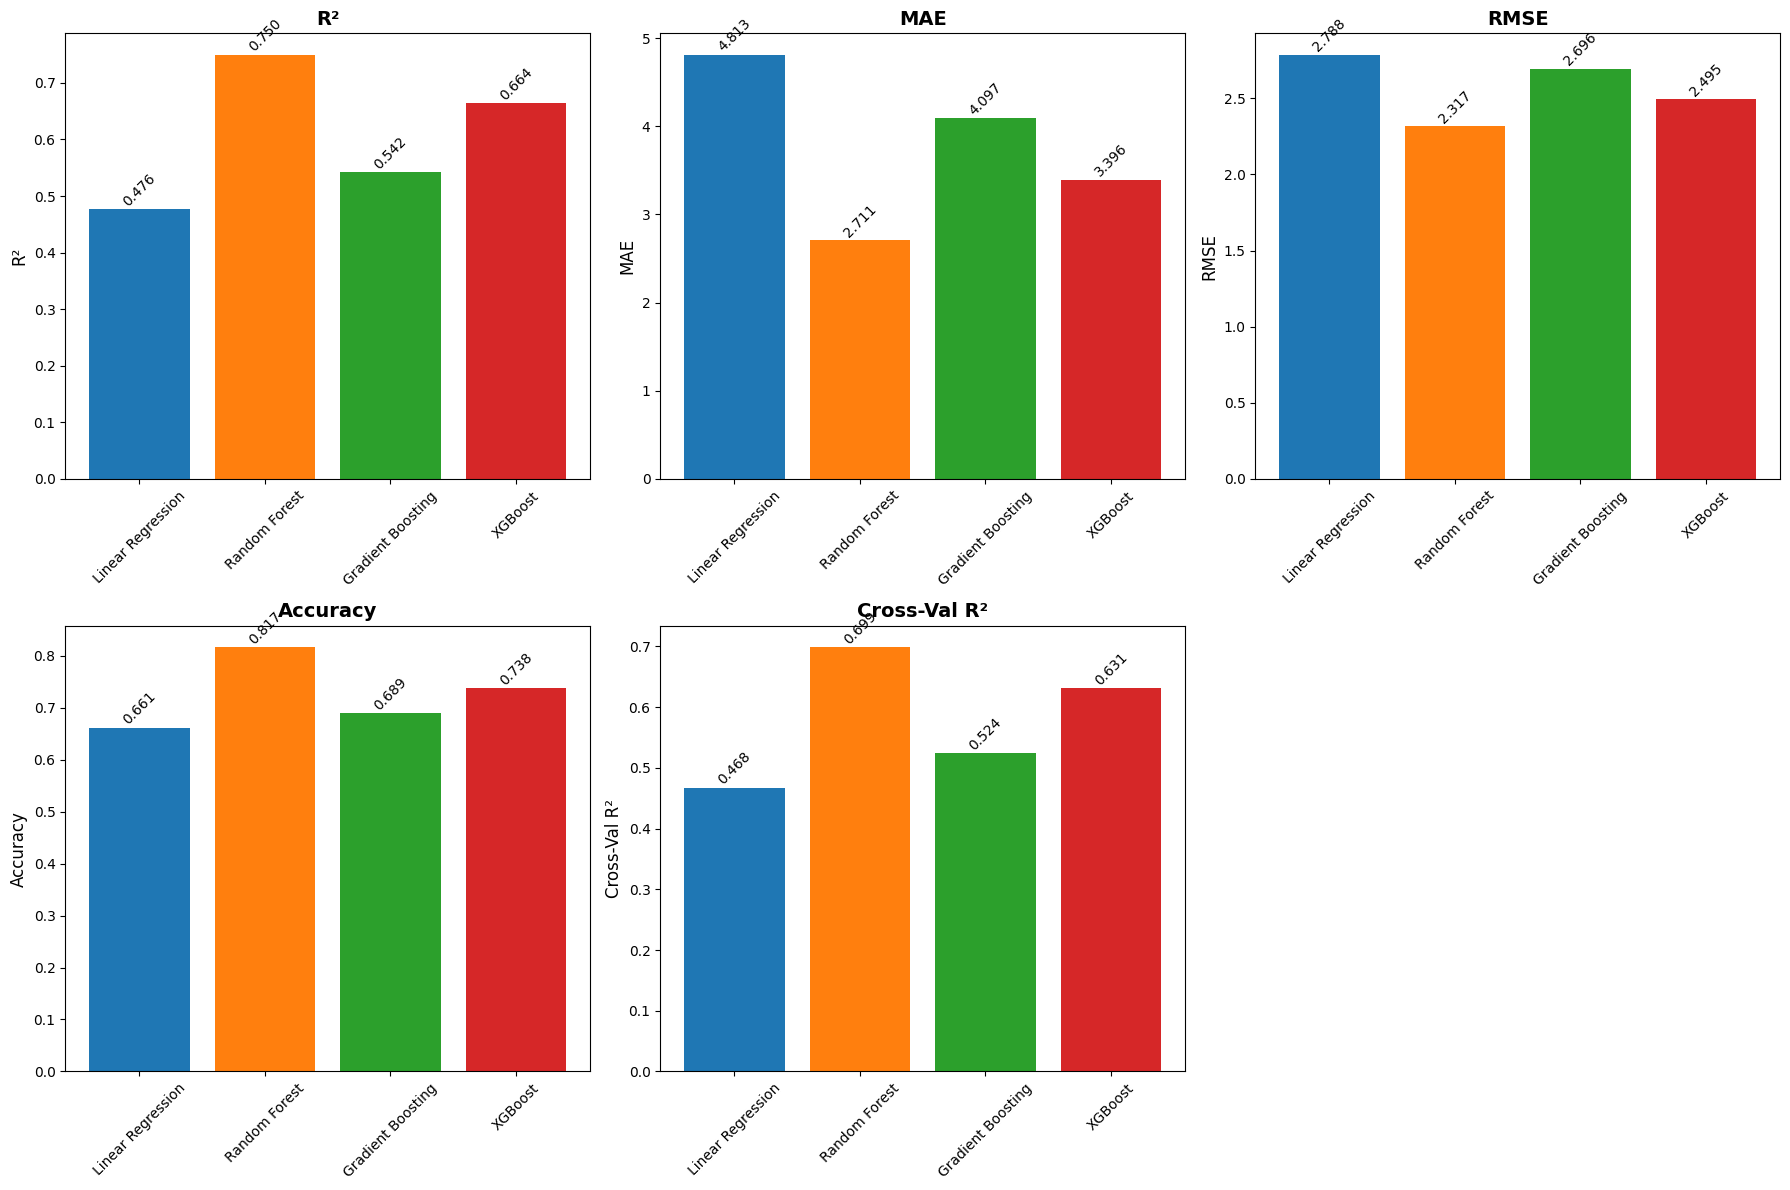

In [22]:
generate_graph_v3(result_exp_2)

## Exp 3: Test the models with GridSearchCV 

In [29]:
def print_metrics(y_test, y_pred, model):
    # Calculate the new metrics
    rmse = np.sqrt(root_mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    correct_predictions = np.abs(y_test - y_pred) <= 5.0

    accuracy = np.sum(correct_predictions) / len(y_test)


    print(f"Optimized {model}: RMSE = {rmse:.2f}, R² = {r2:.2f} Accuracy =  {accuracy:.2f}")

In [24]:
from tqdm.auto import tqdm

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define models to test
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'XGBoost': XGBRegressor(random_state=42)
}

# Hyperparameter grids for each model
param_grids = {
    'Linear Regression': {},
    'Random Forest': {'model__n_estimators': [100, 200], 'model__max_depth': [None, 10, 20]},
    'Gradient Boosting': {'model__n_estimators': [100, 200], 'model__learning_rate': [0.01, 0.1]},
    'XGBoost': {'model__n_estimators': [100, 200], 'model__learning_rate': [0.01, 0.1], 'model__max_depth': [3, 5]}
}

# Test models with cross-validation and hyperparameter tuning
results = {}
for name, model in tqdm(models.items(), desc="Training Models"):
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('poly', PolynomialFeatures(degree=2, include_bias=False)),
        ('model', model)
    ])
    
    grid_search = GridSearchCV(pipeline, param_grids[name], cv=5, scoring='r2', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    y_pred = grid_search.predict(X_test)
    results[name] = calculate_metrics(y_test, y_pred)
    results[name]['Best Parameters'] = grid_search.best_params_
    results[name]['Cross-Val R²'] = np.mean(cross_val_score(grid_search.best_estimator_, X_train, y_train, cv=5, scoring='r2'))

# Convert the results to a DataFrame
results_df = pd.DataFrame(results).T

# Display the DataFrame nicely formatted
results_df_formatted = results_df.style.set_caption("Model Testing Results").format("{:.4f}", subset=["R²", "MAE", "RMSE", "Precision", "Accuracy", "Cross-Val R²"])

# Return the DataFrame as the output
results_df_formatted

Training Models:   0%|          | 0/4 [00:00<?, ?it/s]

,R²,MAE,RMSE,Precision,Accuracy,Best Parameters,Cross-Val R²
Linear Regression,0.4570,4.6670,2.8131,0.6713,0.6713,{},-3.1969
Random Forest,0.7542,2.7024,2.3074,0.8156,0.8156,"{'model__max_depth': None, 'model__n_estimators': 200}",0.7030
Gradient Boosting,0.5548,4.0387,2.6769,0.6891,0.6891,"{'model__learning_rate': 0.1, 'model__n_estimators': 200}",0.5377
XGBoost,0.6140,3.7687,2.5830,0.6997,0.6997,"{'model__learning_rate': 0.1, 'model__max_depth': 5, 'model__n_estimators': 200}",0.5887


In [25]:
# Determine the best model based on Cross-Val R²
best_model = max(results, key=lambda x: results[x]['Cross-Val R²'])
print(f"\nBest model based on Cross-Val R²: {best_model}")
print(f"Best Cross-Val R²: {results[best_model]['Cross-Val R²']:.4f}")


Best model based on Cross-Val R²: Random Forest
Best Cross-Val R²: 0.7030


## Exp 4: Test the two best models XGBoost and Random Forest with RandomizedSearchCV 

In [26]:
# Define the parameter grid
param_grid = {
    'n_estimators': [100, 300, 500],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7, 10],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.3, 0.5],
    'reg_alpha': [0, 0.1, 0.5, 1.0],  # L1 regularization
    'reg_lambda': [0.5, 1.0, 1.5]     # L2 regularization
}

# Initialize the XGBoost model
xgb_model = XGBRegressor(random_state=42)

# Randomized search with 5-fold cross-validation
random_search = RandomizedSearchCV(estimator=xgb_model, 
                                   param_distributions=param_grid, 
                                   n_iter=50, 
                                   cv=5, 
                                   verbose=1, 
                                   random_state=42, 
                                   n_jobs=-1)

# Fit the model
random_search.fit(X_train, y_train)

# Get the best parameters
best_params = random_search.best_params_
print(f"Best parameters: {best_params}")

# Evaluate on the test set
best_model_xgb = random_search.best_estimator_
y_pred_xgb = best_model_xgb.predict(X_test)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters: {'subsample': 1.0, 'reg_lambda': 1.0, 'reg_alpha': 1.0, 'n_estimators': 500, 'max_depth': 10, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.6}


In [30]:
print_metrics(y_test, y_pred_xgb, 'XGBoost')

Optimized XGBoost: RMSE = 2.24, R² = 0.78 Accuracy =  0.88


In [31]:
# Define the parameter grid
param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False]
}

# Initialize the Random Forest model
rf_model = RandomForestRegressor(random_state=42)

# Randomized search with 5-fold cross-validation
random_search_rf = RandomizedSearchCV(estimator=rf_model,
                                      param_distributions=param_grid,
                                      n_iter=50,
                                      cv=5,
                                      verbose=1,
                                      random_state=42,
                                      n_jobs=-1)

# Fit the model
random_search_rf.fit(X_train, y_train)

# Get the best parameters
best_params_rf = random_search_rf.best_params_
print(f"Best parameters for Random Forest: {best_params_rf}")

# Evaluate on the test set
best_rf_model = random_search_rf.best_estimator_
y_pred_rf = best_rf_model.predict(X_test)


Fitting 5 folds for each of 50 candidates, totalling 250 fits


/opt/homebrew/anaconda3/envs/OPIT/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
45 fits failed out of a total of 250.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
33 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/homebrew/anaconda3/envs/OPIT/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/homebrew/anaconda3/envs/OPIT/lib/python3.11/site-packages/sklearn/base.py", line 1467, in wrapper
    estimator._validate_params()
  File "/opt/homebrew/anaconda3/envs/OPIT/lib/python3.11/site-packages/sklearn/base.py", line 666, in _validate_params
    va

Best parameters for Random Forest: {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': None, 'bootstrap': False}


In [32]:
print_metrics(y_test, y_pred_rf, 'Random Forest')

Optimized Random Forest: RMSE = 2.27, R² = 0.77 Accuracy =  0.85


## Exp 4: Test the two best models XGBoost and Random Forest with RandomizedSearchCV in ensembled mode

In [33]:
# You already have these two trained models:
# - best_rf_model from the RandomizedSearchCV for RandomForest
# - best_model_xgb from the RandomizedSearchCV for XGBoost

# Define the base models for stacking
estimators = [
    ('random_forest', best_rf_model),
    ('xgboost', best_model_xgb)
]

# Define the meta-model (here, Ridge Regression)
meta_model = Ridge(alpha=1.0)

# Create the Stacking Regressor
stacking_model = StackingRegressor(estimators=estimators, final_estimator=meta_model, cv=5)

# Fit the stacking ensemble model
stacking_model.fit(X_train, y_train)

# Predict on the test set
y_pred_stacking_1 = stacking_model.predict(X_test)

In [34]:
print_metrics(y_test, y_pred_stacking_1,'Stacking Ensemble - using Ridge')

Optimized Stacking Ensemble: RMSE = 2.23, R² = 0.79 Accuracy =  0.87


In [38]:
# Define the base models for stacking
estimators = [
    ('random_forest', best_rf_model),
    ('xgboost', best_model_xgb)
]

# Define the meta-model (here, GradientBoostingRegressor)
meta_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1)


# Create the Stacking Regressor
stacking_model = StackingRegressor(estimators=estimators, final_estimator=meta_model, cv=10) # Previously tried 5

# Fit the stacking ensemble model
stacking_model.fit(X_train, y_train)

# Predict on the test set
y_pred_stacking = stacking_model.predict(X_test)

In [39]:
print_metrics(y_test, y_pred_stacking, 'Stacking Ensemble - using Gradient Boosting')

Optimized Stacking Ensemble - using Gradient Boosting: RMSE = 2.21, R² = 0.79 Accuracy =  0.88


In [40]:
from sklearn.linear_model import ElasticNet

stacking_models = [
    StackingRegressor(estimators=estimators, final_estimator=Ridge(), cv=5),
    StackingRegressor(estimators=estimators, final_estimator=GradientBoostingRegressor(), cv=5),
    StackingRegressor(estimators=estimators, final_estimator=ElasticNet(), cv=5)
]

y_pred_ensemble_multiple_models = np.mean([model.fit(X_train, y_train).predict(X_test) for model in stacking_models], axis=0)

In [41]:
print_metrics(y_test, y_pred_ensemble_multiple_models, 'Stacking Ensemble - using multiple models')

Optimized Stacking Ensemble - using multiple models: RMSE = 2.22, R² = 0.79 Accuracy =  0.88


In [44]:
from sklearn.ensemble import BaggingRegressor

bagged_stacking = BaggingRegressor(estimator=stacking_model, n_estimators=10, random_state=42)
bagged_stacking.fit(X_train, y_train)
y_pred_bagged = bagged_stacking.predict(X_test)

In [45]:
print_metrics(y_test, y_pred_bagged, 'Stacking Ensemble - using Bagging')

Optimized Stacking Ensemble - using Bagging: RMSE = 2.33, R² = 0.74 Accuracy =  0.80


In [46]:
import pickle
import joblib
import os

# Assuming 'stacking_model' is your fitted model

# Create a directory to save the model (if it doesn't exist)
if not os.path.exists('saved_models'):
    os.makedirs('saved_models')

# Save the model using pickle
with open('saved_models/stacking_model.pkl', 'wb') as file:
    pickle.dump(stacking_model, file)

# Alternatively, you can use joblib, which is more efficient for large numpy arrays
joblib.dump(stacking_model, 'saved_models/stacking_model.joblib')

print("Model saved successfully!")

Model saved successfully!
